<a href="https://www.kaggle.com/code/bcscuwe1/titanic-classification?scriptVersionId=197797932" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# The Problem
Develop an algorithm to predict the survival outcome of passengers on the Titanic

-------------------------------

**Project Summary**: The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

Titanic was a British passenger liner, operated by the White Star Line, which sank in the North Atlantic Ocean on 15 April 1912 after striking an iceberg during her maiden voyage from Southampton, England, to New York City, United States. Of the estimated 2,224 passengers and crew aboard, more than 1,500 died, making it the deadliest sinking of a single ship up to that time. It remains the deadliest peacetime sinking of an ocean liner or cruise ship.

Titanic had advanced safety features, such as watertight compartments and remotely activated watertight doors, contributing to its reputation as "unsinkable". The ocean liner carried some of the wealthiest people in the world, as well as hundreds of emigrants from Great Britain and Ireland, Scandinavia, and elsewhere throughout Europe, who were seeking a new life in the United States and Canada.

Titanic was equipped with 16 lifeboat davits, each capable of lowering three lifeboats, for a total of 48 boats; she carried only 20 lifeboats, four of which were collapsible and proved hard to launch while she was sinking (Collapsible A nearly swamped and was filled with a foot of water until rescue, Collapsible B completely overturned while launching). Together, the 20 lifeboats could hold 1,178 people—about half the number of passengers on board, and one third of the number of passengers the ship could have carried at full capacity (consistent with the maritime safety regulations of the era). When the ship sank, many of the lifeboats that had been lowered were only about half full.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

**In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.**

In [98]:
import numpy as np  # linear algebra
import pandas as pd # train processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline 
# magic command that allows the plots to be displayed directly in the Jupyter Notebook.
import seaborn as sns # train visualization library based on matplotlib that provides a high-level interface for creating attractive and informative statistical graphics
import sklearn # A machine learning library in Python that provides a range of tools for train analysis, modeling, and evaluation.

pd.set_option('display.max_columns',500) 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [99]:
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, chi2, mutual_info_classif, SelectFromModel

# Read train

In [100]:
train = pd.read_csv('/kaggle/input/titanic/train.csv', index_col='PassengerId')
valid = pd.read_csv('/kaggle/input/titanic/test.csv', index_col='PassengerId')
sub = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

In [101]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [102]:
valid.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# UnderStanding train

*    PassengerId is the unique id of the row and it doesn't have any effect on target
*    Survived is the target variable we are trying to predict (0 or 1):
    * 1 = Survived
    * 0 = Not Survived
* Pclass (Passenger Class) is the socio-economic status of the passenger and it is a categorical ordinal feature which has 3 unique values (1, 2 or 3):
    * 1 = Upper Class
    * 2 = Middle Class
    * 3 = Lower Class
* Name, Sex and Age are self-explanatory
* SibSp is the total number of the passengers' siblings and spouse
* Parch is the total number of the passengers' parents and children
* Ticket is the ticket number of the passenger
* Fare is the passenger fare
* Cabin is the cabin number of the passenger
* Embarked is port of embarkation and it is a categorical feature which has 3 unique values (C, Q or S):
    * C = Cherbourg
    * Q = Queenstown
    * S = Southampton

Which features are available in the trainset?

**Which features are categorical?**

   * Categorical: **Survived, Sex, and Embarked**.
   * Ordinal: **Pclass**.
    
**What is the distribution of categorical features?**

* Names are unique across the trainset (count=unique=891)
* Sex variable as two possible values with 65% male (top=male, freq=577/count=891).
* Cabin values have several dupicates across samples. Alternatively several passengers shared a cabin.
* Embarked takes three possible values. S port used by most passengers (top=S)
* Ticket feature has high ratio (22%) of duplicate values (unique=681).

**Which features are numerical?**

   * Continous: **Age, Fare.**
   * Discrete: **SibSp, Parch.**
    
**What is the distribution of numerical feature values across the samples?**

This helps us determine, among other early insights, how representative is the training trainset of the actual problem domain.

* Total samples are 891 or 40% of the actual number of passengers on board the Titanic (2,224).
* Survived is a categorical feature with 0 or 1 values.
* Around 38% samples survived representative of the actual survival rate at 32%.
* Most passengers (> 75%) did not travel with parents or children.
* Nearly 30% of the passengers had siblings and/or spouse aboard.
* Fares varied significantly with few passengers (<1%) paying as high as $512.
* Few elderly passengers (<1%) within age range 65-80.

**Which features are mixed train types?**

Numerical, alphanumeric train within same feature. These are candidates for correcting goal.

* Ticket is a mix of numeric and alphanumeric train types. Cabin is alphanumeric.

**Which features may contain errors or typos?**

This is harder to review for a large trainset, however reviewing a few samples from a smaller trainset may just tell us outright, which features may require correcting.

* Name feature may contain errors or typos as there are several ways used to describe a name including titles, round brackets, and quotes used for alternative or short names.

In [103]:
train.info(),print('\n'), valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 n

(None, None, None)

In [104]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Let See Unique Values and their count

In [105]:
value_df = train.copy(deep=True)
for col in value_df.columns:
    value_df[col] = value_df[col].astype('str')
    print(f"There are {value_df[col].nunique()} Unique valuse in Column '{col}'.")
    if train[col].nunique() < 150:
        print(f"\nUnique values in '{col}' column: {sorted(value_df[col].unique().tolist())}")
        df = pd.DataFrame(value_df[col].value_counts().values, columns=['Value'], index=value_df[col].value_counts().index)
        df['Percentage'] = value_df[col].value_counts(normalize=True)*100
        print(df)
    print()
    print("--"*50)

There are 2 Unique valuse in Column 'Survived'.

Unique values in 'Survived' column: ['0', '1']
   Value  Percentage
0    549   61.616162
1    342   38.383838

----------------------------------------------------------------------------------------------------
There are 3 Unique valuse in Column 'Pclass'.

Unique values in 'Pclass' column: ['1', '2', '3']
   Value  Percentage
3    491   55.106622
1    216   24.242424
2    184   20.650954

----------------------------------------------------------------------------------------------------
There are 891 Unique valuse in Column 'Name'.

----------------------------------------------------------------------------------------------------
There are 2 Unique valuse in Column 'Sex'.

Unique values in 'Sex' column: ['female', 'male']
        Value  Percentage
male      577   64.758698
female    314   35.241302

----------------------------------------------------------------------------------------------------
There are 89 Unique valuse in Colu

# Feature Engineering

for outliers Max Values in Age and Fare are too far from values in 75% quatite, we should address these values as outliers. For 'Age', I will use robust scaling and bins. For 'Fare', based on Distribution replace high values with upper bound as well as apply bins

there missing value in both train and test, i will check if they are random at random or not, then apply conditions based impution on personal expetise.

New features

* **Title**: I will extract title from Name column and apply encoding.

* **Last Name**: Family Name could be helpful.

* **Family Size** can be calculate by summing the member of family acompanying them(+1 is for person itself):

    1. sibsp: The trainset defines family relations in this way...

        * Sibling = brother, sister, stepbrother, stepsister.

        * Spouse = husband, wife (mistresses and fiancés were ignored).

    2. parch: The trainset defines family relations in this way...
        * Parent = mother, father

        * Child = daughter, son, stepdaughter, stepson.

        * Some children travelled only with a nanny, therefore parch=0 for them.
     
* **isAlone**: If Family Size is 1 then person was travelling Alone. I investigate Alone person colrelation Survived


* **Fare Bin**: Quantile-based discretization function.

* **Age Bin**: values into discrete intervals.


        Continuous variable bins; qcut vs cut: https://stackoverflow.com/questions/30211923/what-is-the-difference-between-pandas-qcut-and-pandas-cut
        
        
* **Cabin Level**: First Letter of Cabin to advocate for priority.


## Outliers

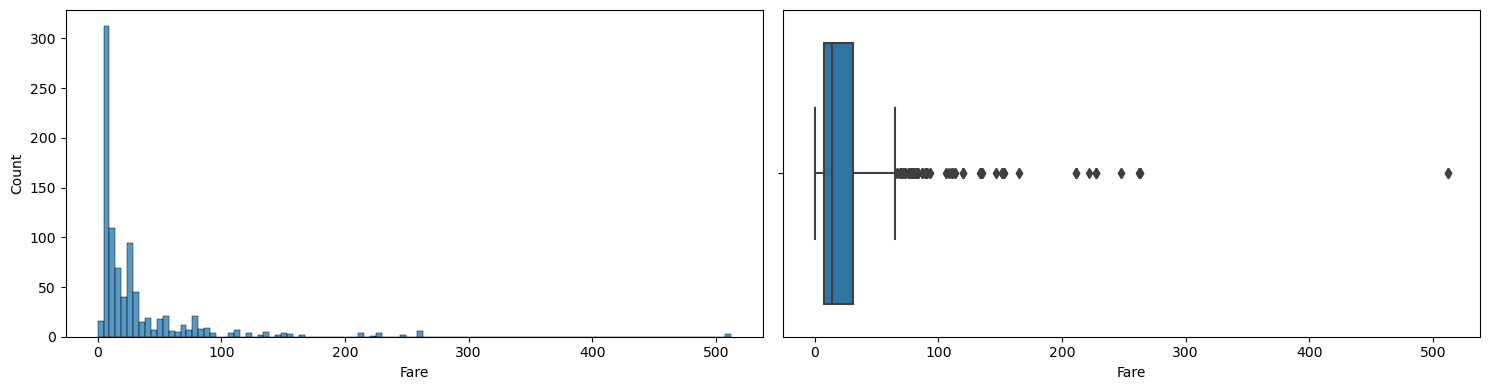

In [106]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))  # Adjusted figsize to match the subplot layout

# Histogram
sns.histplot(data=train, x='Fare', ax=ax[0])
# Boxplot
sns.boxplot(data=train, x='Fare', ax=ax[1])

plt.tight_layout()  # To prevent overlapping of plots
plt.show()

The distribution is right-skewed with non-extreme outliers. To handle these outliers, I replaced them with an upper bound calculated as the 75th percentile (Q3) plus 1.5 times the interquartile range (IQR). Since fare values cannot be negative, there is no need to set a lower bound.

In [107]:
col = train['Fare'].copy(deep=True)
quan_75 = col.quantile(.75)  #31.0
quan_25 = col.quantile(.25)  #7.9104
IQR = quan_75 - quan_25         #23.0896
upper_bound = quan_75 + IQR * 1.5
train['Fare'] = col.mask(col>upper_bound, upper_bound)

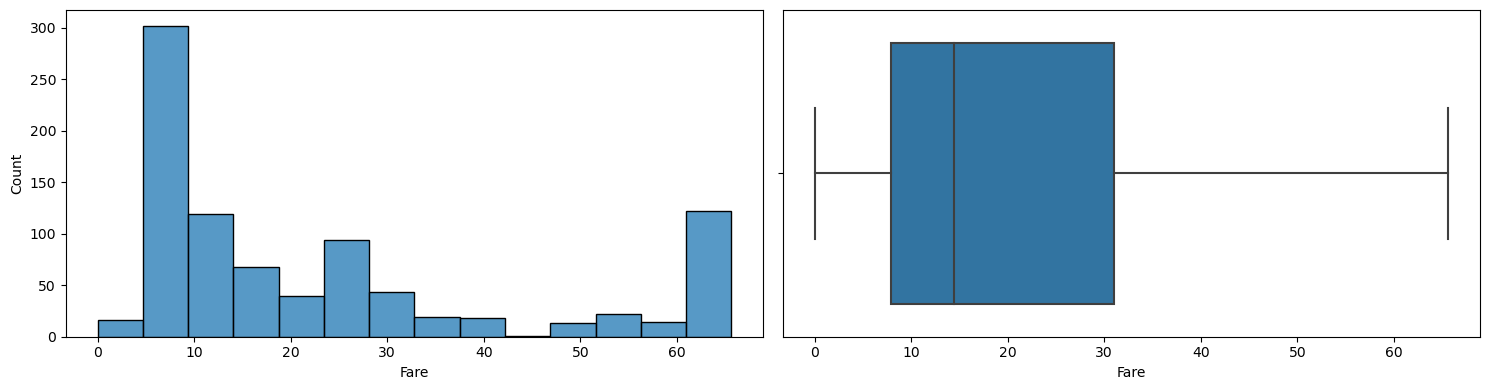

In [108]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))  # Adjusted figsize to match the subplot layout

# Histogram
sns.histplot(data=train, x='Fare', ax=ax[0])
# Boxplot
sns.boxplot(data=train, x='Fare', ax=ax[1])

plt.tight_layout()  # To prevent overlapping of plots
plt.show()

Must better, transformation is require for normal distribution

To check if 'Age' missing values are Missing Completely at Random (MCAR), Missing At Random (MAR), Missing Not at Random (MNAR)

Little's MCAR (Missing Completely at Random) test using logistic regression. This test is used to assess whether the missing data in a dataset is missing completely at random (MCAR) or if there is a systematic pattern to the missingness.

In [109]:
import statsmodels.api as sm

# Copy DataFrame
df = train.copy(deep=True)
# Create a binary indicator for missing values in a specific column
df['missing_indicator'] = np.where(df['Age'].isnull(), 1, 0)
df['Sex_indicator'] = np.where(df['Sex']=='female', 1, 0)

# Add constant for logistic regression
df['intercept'] = 1

# Logistic regression
logit_model = sm.Logit(df['missing_indicator'], df[['intercept', 'Fare', 'Pclass', 'Sex_indicator']])
result = logit_model.fit()

result.summary()

Optimization terminated successfully.
         Current function value: 0.481753
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      missing_indicator   No. Observations:                  891
Model:                          Logit   Df Residuals:                      887
Method:                           MLE   Df Model:                            3
Date:                Sun, 22 Sep 2024   Pseudo R-squ.:                 0.03365
Time:                        14:06:09   Log-Likelihood:                -429.24
converged:                       True   LL-Null:                       -444.19
Covariance Type:            nonrobust   LLR p-value:                 1.451e-06
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept        -2.6790      0.498     -5.381      0.000      -3.655      -1.703
Fare             -0.0011      0.006     -0.177      0.860      -0.014       0.012
Pclass            0.5626      0.157      3.595      0.000       0.256       0.869
Sex_indicator    -0.1764      0.188     -0.938      0.348      -0.545       0.192
=================================================================================
"""

Interpretation:

* Coefficient: The intercept term is -2.6618. In a logistic regression model, the intercept represents the log-odds of the outcome when all predictors are at their reference values (e.g., zero).
* Statistical Significance: The p-value is very small (0.000), indicating that the intercept is statistically significant.
* Confidence Interval: The 95% confidence interval for the intercept does not include zero, further confirming its statistical significance.

age is missing not completely at random, so capturing nan values with new features

In [110]:
columns_missing = ["Age"]
for col in columns_missing:
    train[col+' Missing'] = train[col].apply(lambda x: 1 if pd.isna(x) else 0)

train['Title'] = train['Name'].str.split(", ",expand=True)[1].str.split(". ",expand=True)[0]
train['Last Name'] = train['Name'].str.split(",", expand=True)[0]
train['Family Size'] = train['SibSp'] + train['Parch'] + 1
train['isAlone'] = train['Family Size'].apply(lambda x: 1 if x == 1 else 0)
train['Cabin'].fillna("Missing", inplace=True)
train['Cabin Level'] = train['Cabin'].astype('str').str[0]

# Since, 70% of 'Cabin' is missing and 'Name' is not need anymore. I will drop this features
train.drop(['Cabin', 'Name'], axis=1, inplace=True)

## Imputation

'Embarked': The column have two missing values with fare 80, pclass 1, cabin B28, same Ticket number. 

'Age': fillup on expatise conditaions

'Fare': use train dataset to fill test value

https://www.mastersindatascience.org/learning/how-to-deal-with-missing-data/

In [111]:
print('Train trainset\n{}'.format(train.isnull().sum()))

Train trainset
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
Age Missing      0
Title            0
Last Name        0
Family Size      0
isAlone          0
Cabin Level      0
dtype: int64


### Emabarked: Port of Embarkation

C = Cherbourg, Q = Queenstown, S = Southampton

first i have to check how data is missing.

In [112]:
train[train['Embarked'].isnull() == True]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age Missing,Title,Last Name,Family Size,isAlone,Cabin Level
PassengerId,,,,,,,,,,,,,,,
62,1,1,female,38.0,0,0,113572,65.6344,NaN,0,Miss,Icard,1,1,B
830,1,1,female,62.0,0,0,113572,65.6344,NaN,0,Mrs,Stone,1,1,B


The two missing values have fare 80, pclass 1, cabin B28, same Ticket number **(maybe data is mismatch)**. My conclusion these values are not arbitrary.

From countplot we see Embarked C is common around for Pclass 1 above Fare 60 and gender Female.

Since "Embarked" is a categorical variable, I will use the mode (most frequent value) with conditions.

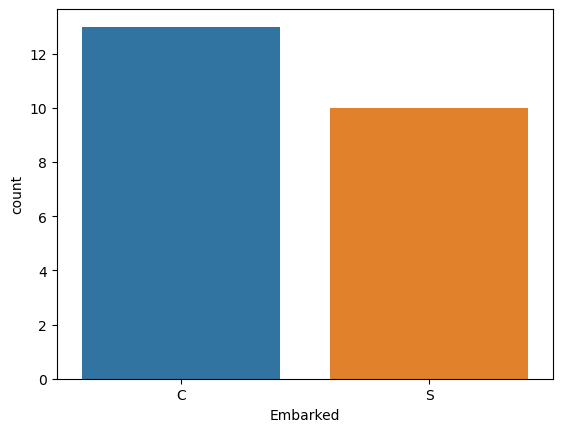

In [113]:
embark = train.loc[(train['Pclass']==1) & (train['Fare']>60) & (train['Sex']=='female') & (train['isAlone']==1)]
sns.countplot(embark, x='Embarked');

train['Embarked'].fillna(embark['Embarked'].mode()[0], inplace=True)

### Fare: Passenger fare

We will use train dataset with conditions to fillna in test to avoid overfitting.

In [114]:
fare_miss = valid[valid['Fare'].isnull()]
fare_miss

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [115]:
train[['Embarked', 'Pclass', 'Age', 'Sex', 'SibSp', 'Parch']].corrwith(train['Fare'], numeric_only=True)

Pclass   -0.715300
Age       0.151920
SibSp     0.332021
Parch     0.292616
dtype: float64

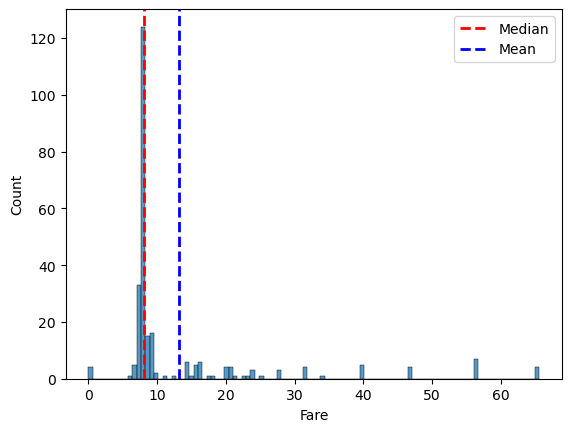

In [116]:
fare = train[(train['Pclass']==3) & (train['Sex']=='male') & (train['Embarked']=='S') ]
sns.histplot(fare['Fare'])
plt.axvline(fare['Fare'].median(), color='red', linestyle='dashed', linewidth=2, label='Median')
plt.axvline(fare['Fare'].mean(), color='blue', linestyle='dashed', linewidth=2, label='Mean')
plt.legend()
plt.show()

Correlation helps in deciding which conditions to apply when handling missing values. Since the feature shows a 'right-skewed' distribution, using the `median` is more appropriate for filling `NaN` values, as it is less sensitive to outliers than the `mean`.

In [117]:
valid['Fare'].fillna(fare['Fare'].median(), inplace=True)

### Age

263 rows have null value in age column. we seprate the child one from adult using title in name. 

Utilized **mask()** to fill values with condition.

In Miss,Mrs,Mr, Case: we will class condition to get the mean.

In Master Case: we have missing values only in 3rd class.

From jointplot, Miss case Distribution is right skewed, thus use median. Mrs, Mr case Distribution is normal, thus using mean

In [118]:
train.loc[train['Age'].isnull(), 'Title'].value_counts()

Mr        119
Miss       36
Mrs        17
Master      4
Dr          1
Name: Title, dtype: int64

### Miss Case

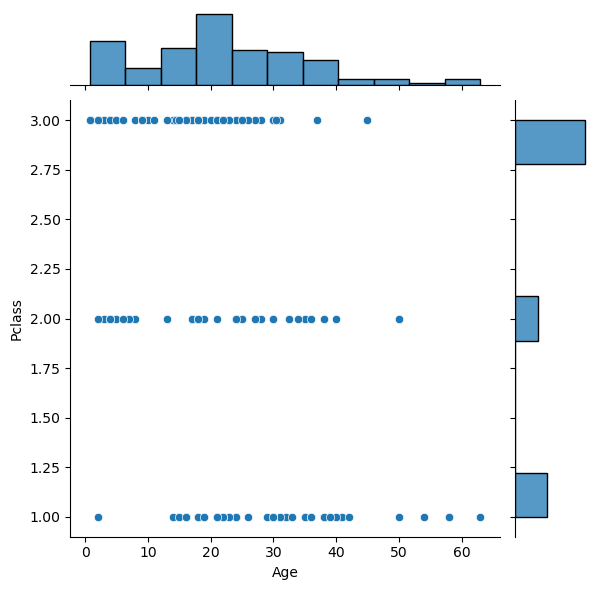

In [119]:
miss_df = train.loc[(train['Title']=='Miss')]
sns.jointplot(miss_df, x='Age', y='Pclass')

mr1_age = train.loc[(train['Title'] == 'Miss') & (train['Pclass'] == 1), 'Age'].median()
mr2_age = train.loc[(train['Title'] == 'Miss') & (train['Pclass'] == 2), 'Age'].median()
mr3_age = train.loc[(train['Title'] == 'Miss') & (train['Pclass'] == 3), 'Age'].median()

# Filling Values
train['Age'] = train['Age'].mask((train['Title'] == 'Miss') & (train['Pclass'] == 1) & train['Age'].isnull(), mr1_age)
train['Age'] = train['Age'].mask((train['Title'] == 'Miss') & (train['Pclass'] == 2) & train['Age'].isnull(), mr2_age)
train['Age'] = train['Age'].mask((train['Title'] == 'Miss') & (train['Pclass'] == 3) & train['Age'].isnull(), mr3_age)

### Mrs Case

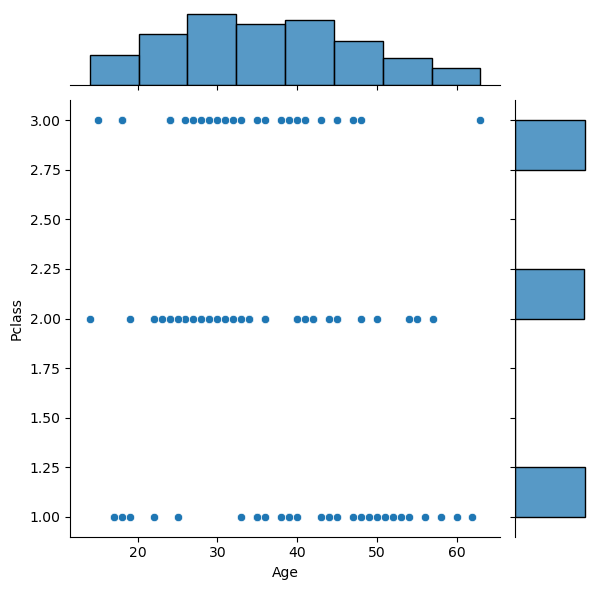

In [120]:
mrs_df = train.loc[(train['Title']=='Mrs')]
sns.jointplot(mrs_df, x='Age', y='Pclass')

mr1_age = train.loc[(train['Title'] == 'Mrs') & (train['Pclass'] == 1), 'Age'].mean()
mr2_age = train.loc[(train['Title'] == 'Mrs') & (train['Pclass'] == 2), 'Age'].mean()
mr3_age = train.loc[(train['Title'] == 'Mrs') & (train['Pclass'] == 3), 'Age'].mean()

# Filling value
train['Age'] = train['Age'].mask((train['Title'] == 'Mrs') & (train['Pclass'] == 1) & train['Age'].isnull(), mr1_age)
train['Age'] = train['Age'].mask((train['Title'] == 'Mrs') & (train['Pclass'] == 2) & train['Age'].isnull(), mr2_age)
train['Age'] = train['Age'].mask((train['Title'] == 'Mrs') & (train['Pclass'] == 3) & train['Age'].isnull(), mr3_age)

### Mr Case

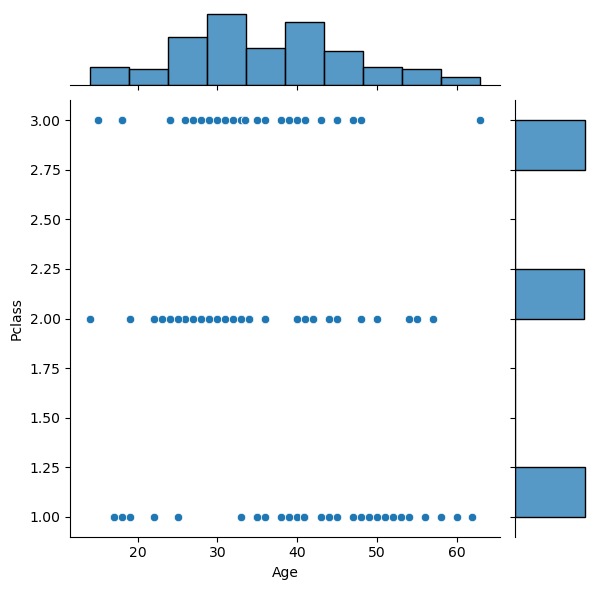

In [121]:
mr_df = train.loc[(train['Title']=='Mrs')]
sns.jointplot(mr_df, x='Age', y='Pclass')

mr1_age = train.loc[(train['Title'] == 'Mr') & (train['Pclass'] == 1), 'Age'].mean()
mr2_age = train.loc[(train['Title'] == 'Mr') & (train['Pclass'] == 2), 'Age'].mean()
mr3_age = train.loc[(train['Title'] == 'Mr') & (train['Pclass'] == 3), 'Age'].mean()

# filling values
train['Age'] = train['Age'].mask((train['Title'] == 'Mr') & (train['Pclass'] == 1) & train['Age'].isnull(), mr1_age)
train['Age'] = train['Age'].mask((train['Title'] == 'Mr') & (train['Pclass'] == 2) & train['Age'].isnull(), mr2_age)
train['Age'] = train['Age'].mask((train['Title'] == 'Mr') & (train['Pclass'] == 3) & train['Age'].isnull(), mr3_age)

### Dr case

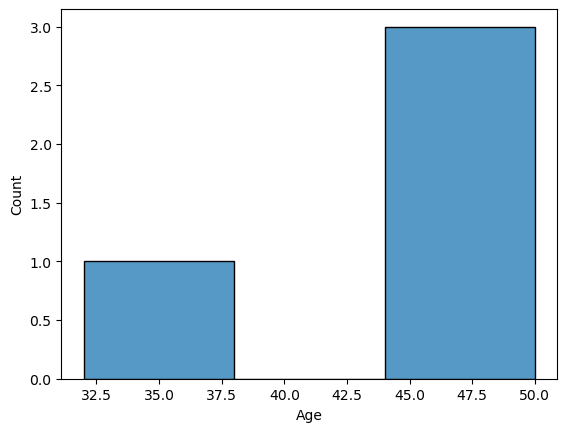

In [122]:
dr_df = train.loc[(train['Title']=='Dr') & (train['Pclass']==1)]
sns.histplot(dr_df, x='Age')

# Filling value
train['Age'] = train['Age'].mask((train['Title'] == 'Dr') & train['Age'].isnull(), dr_df.Age.median())

### Master Case



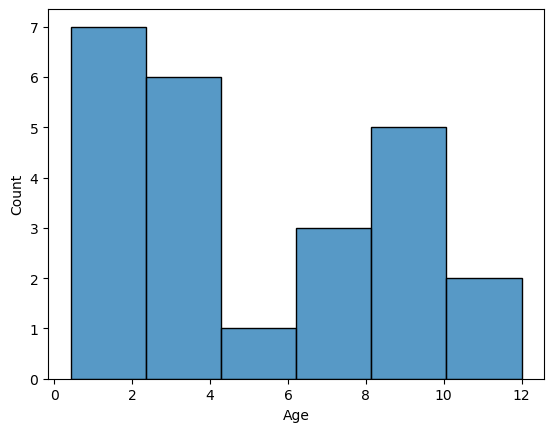

In [123]:
master_df = train.loc[(train['Title']=='Master') & (train['Pclass']==3)]
sns.histplot(master_df, x='Age')

# Filling value
train['Age'] = train['Age'].mask((train['Title'] == 'Master') & train['Age'].isnull(), master_df['Age'].median())

### Double Checking Null Values

In [124]:
print('Train trainset\n{}'.format(train.isnull().sum()))

Train trainset
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Age Missing    0
Title          0
Last Name      0
Family Size    0
isAlone        0
Cabin Level    0
dtype: int64


In [125]:
train['Children'] = np.where(train['Age']<=18, 1, 0)
train['Fare qcut'] = pd.qcut(train['Fare'],5)
train['Age cut'] = pd.cut(train['Age'],5)

# Analytics

In [126]:
title_df = train.copy()
# group title
title_group = {
    'Capt': 'Mr',
    'Col': 'Mr',
    'Don': 'Mr',
    'Dr': 'Mr',  # Doctor can be categorized as 'Mr' or 'Mrs' depending on gender
    'Jonkheer': 'Mr',
    'Lady': 'Mrs',  # Female nobility, can be categorized as 'Mrs'
    'Major': 'Mr',
    'Master': 'Master',  # This is a unique title for boys
    'Miss': 'Miss',
    'Mlle': 'Miss',  # Mademoiselle (French equivalent of Miss)
    'Mme': 'Mrs',  # Madame (French equivalent of Mrs)
    'Mr': 'Mr',
    'Mrs': 'Mrs',
    'Ms': 'Mrs',  # Often interchangeable with 'Mrs'
    'Rev': 'Mr',  # Reverend can be categorized as 'Mr'
    'Sir': 'Mr',  # Male nobility
    'th': 'Mrs'  # Specific noble title
}
title_df['Title'] = title_df['Title'].map(title_group)

In [127]:
title_df.groupby(['Title', 'isAlone'])['Survived'].count()

Title   isAlone
Master  0           40
Miss    0           82
        1          102
Mr      0          126
        1          412
Mrs     0          106
        1           23
Name: Survived, dtype: int64

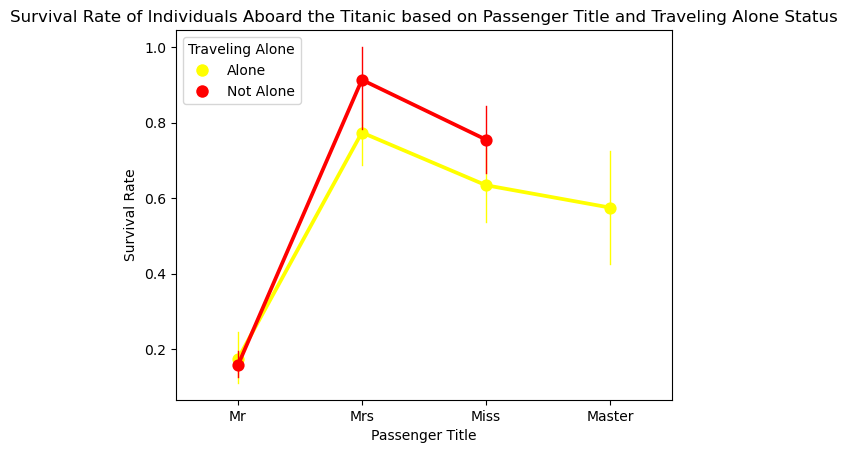

In [128]:
sns.pointplot(title_df, hue='isAlone', x='Title', y='Survived', palette=['Yellow', 'Red'], errwidth=1)
plt.xlabel('Passenger Title')
plt.ylabel('Survival Rate')
plt.title('Survival Rate of Individuals Aboard the Titanic based on Passenger Title and Traveling Alone Status')

# Create custom legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Alone', markerfacecolor='Yellow', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Not Alone', markerfacecolor='Red', markersize=10)
]
plt.legend(handles=legend_elements, title='Traveling Alone', loc='upper left')
plt.show()

The survival rate for 'Mr.' remains the same regardless of whether they were traveling alone or with family. However, for 'Mrs.' and 'Miss,' survival rates increased when they were with family, indicating that family presence significantly affected their chances of survival.

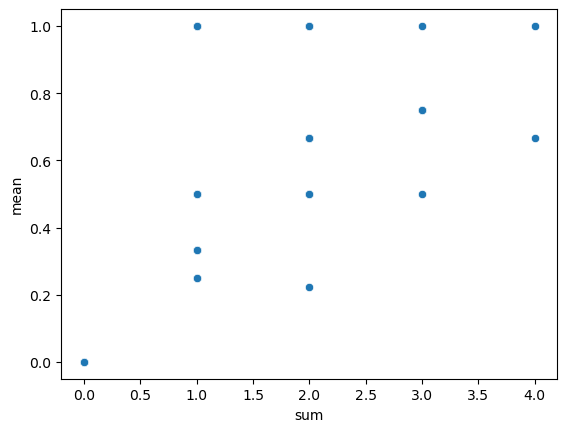

In [129]:
last_scatter_df = train.groupby(['Last Name'])['Survived'].agg(['sum', 'mean']).sort_values(by='mean', ascending=False)
sns.scatterplot(last_scatter_df, x='sum', y='mean');

## Encoding

In [130]:
train.select_dtypes(include=['object', 'category']).head()

,Sex,Ticket,Embarked,Title,Last Name,Cabin Level,Fare qcut,Age cut
PassengerId,,,,,,,,
1,male,A/5 21171,S,Mr,Braund,M,"(-0.001, 7.854]","(16.336, 32.252]"
2,female,PC 17599,C,Mrs,Cumings,C,"(39.688, 65.634]","(32.252, 48.168]"
3,female,STON/O2. 3101282,S,Miss,Heikkinen,M,"(7.854, 10.5]","(16.336, 32.252]"
4,female,113803,S,Mrs,Futrelle,C,"(39.688, 65.634]","(32.252, 48.168]"
5,male,373450,S,Mr,Allen,M,"(7.854, 10.5]","(32.252, 48.168]"


In [131]:
display(train.groupby(['Fare qcut'])['Survived'].mean())

fare_mean = train.groupby(['Fare qcut'])['Survived'].mean().to_dict()
train['Fare qcut'] = train['Fare qcut'].map(fare_mean)

Fare qcut
(-0.001, 7.854]     0.217877
(7.854, 10.5]       0.201087
(10.5, 21.679]      0.424419
(21.679, 39.688]    0.444444
(39.688, 65.634]    0.642045
Name: Survived, dtype: float64

In [132]:
display(train.groupby(['Age cut'])['Survived'].mean())

age_mean = train.groupby(['Age cut'])['Survived'].mean().to_dict()
train['Age cut'] = train['Age cut'].map(age_mean)

Age cut
(0.34, 16.336]      0.548077
(16.336, 32.252]    0.332627
(32.252, 48.168]    0.412766
(48.168, 64.084]    0.434783
(64.084, 80.0]      0.090909
Name: Survived, dtype: float64

In [133]:
# Target Mean encoding on 'Embarked'
display(train.groupby(['Embarked'])['Survived'].mean())

embarked_mean = train.groupby(['Embarked'])['Survived'].mean().to_dict()
train['Embarked'] = train['Embarked'].map(embarked_mean)

Embarked
C    0.558824
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

In [134]:
# Target Mean encoding on 'Cabin Level'
display(train.groupby(['Cabin Level'])['Survived'].mean())

cabin_mean = train.groupby(['Cabin Level'])['Survived'].mean().to_dict()
train['Cabin Level'] = train['Cabin Level'].map(cabin_mean)

Cabin Level
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
M    0.299854
T    0.000000
Name: Survived, dtype: float64

In [135]:
# count encoding on 'Last Name' feature
display(train['Last Name'].value_counts())
train['Last Name Count'] = train['Last Name'].map(train['Last Name'].value_counts().to_dict())

Andersson    9
Sage         7
Panula       6
Skoog        6
Carter       6
            ..
Hanna        1
Lewy         1
Mineff       1
Haas         1
Dooley       1
Name: Last Name, Length: 667, dtype: int64

In [136]:
# Probability Ratio encoding on 'sex' feature
prob_ratio_df = pd.DataFrame(train.groupby(['Sex'])['Survived'].mean())
prob_ratio_df['died'] = 1 - prob_ratio_df['Survived']
prob_df = (prob_ratio_df['Survived']/prob_ratio_df['died']).to_dict()
display(prob_df)
train['Sex_Probability'] = train['Sex'].map(prob_df)

{'female': 2.876543209876542, 'male': 0.23290598290598288}

In [137]:
pd.crosstab(train['Title'], train['Sex'], values=train['Survived'], aggfunc='mean').T.style.background_gradient(cmap='summer_r')

Title,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,th
Sex,,,,,,,,,,,,,,,,,
female,nan,nan,nan,1.000000,nan,1.000000,nan,nan,0.697802,1.000000,1.000000,nan,0.792000,1.000000,nan,nan,1.000000
male,0.000000,0.500000,0.000000,0.333333,0.000000,nan,0.500000,0.575000,nan,nan,nan,0.156673,nan,nan,0.000000,1.000000,nan


In [138]:
# Mean encoding based on 'Sex' and Top N One-Hot Encoding on 'Title' feature. 
# This is done to capture both survive priority of title and gender
# mean encoding accoding to sex, title with respect to survived
mean_df = train.groupby(['Sex', 'Title'])['Survived'].mean().reset_index()
mean_dict = mean_df.set_index(['Sex', 'Title'])['Survived'].to_dict()
train['Title_Mean'] = train.set_index(['Sex', 'Title']).index.map(mean_dict)

# apply one hot encoding to only top most title
top = 5
top = [x for x in train['Title'].value_counts().sort_values(ascending=False).head(top).index]
for label in top:
    train[label] = np.where(train["Title"]==label,1,0)

In [139]:
train.drop(['Title', 'Last Name'], axis=1, inplace=True)

In [140]:
# Hashing Encoding on 'Ticket' since more than 850+ values

encoder = ce.HashingEncoder(cols=['Ticket'])
df = encoder.fit_transform(train['Ticket'])
train['Ticket'] = df.apply(lambda x: ''.join(str(x[col]) for col in df.columns), axis=1)

In [141]:
# converting 'Sex' to binary
train['Sex'] = np.where(train['Sex']=='female', 1, 0)

In [142]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age Missing,Family Size,isAlone,Cabin Level,Children,Fare qcut,Age cut,Last Name Count,Sex_Probability,Title_Mean,Mr,Miss,Mrs,Master,Dr
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,
1,0,3,0,22.0,1,0,00100000,7.2500,0.336957,0,2,0,0.299854,0,0.217877,0.332627,2,0.232906,0.156673,1,0,0,0,0
2,1,1,1,38.0,1,0,00000001,65.6344,0.558824,0,2,0,0.593220,0,0.642045,0.412766,1,2.876543,0.792000,0,0,1,0,0
3,1,3,1,26.0,0,0,00001000,7.9250,0.336957,0,1,1,0.299854,0,0.201087,0.332627,1,2.876543,0.697802,0,1,0,0,0
4,1,1,1,35.0,1,0,00000001,53.1000,0.336957,0,2,0,0.593220,0,0.642045,0.412766,2,2.876543,0.792000,0,0,1,0,0
5,0,3,0,35.0,0,0,00001000,8.0500,0.336957,0,1,1,0.299854,0,0.201087,0.412766,2,0.232906,0.156673,1,0,0,0,0


In [143]:
%%script false --no-raise-error

class HashingEncoder(Encoder):
    def __init__(self, cols=None):
        self.cols = cols
        
    def implement(self, X):
        for col in self.cols:
            encoder = ce.HashingEncoder(cols=col, return_df=True)
            df = encoder.fit_transform(X[col])
            X[col] = df.apply(lambda x: ''.join(str(x[column]) for column in df.columns), axis=1)
        return X
    
class ProbabilityRatioEncoder(Encoder):
    def __init__(self, cols=None):
        self.cols = cols
        
    def implement(self, X, y=None):
        for col in self.cols:
                prob_df = pd.concat([X[col], y], axis=1).groupby(col)[y.name].agg(['mean', 'count'])
                prob_df['prob_1'] = prob_df['mean']  
                prob_df['prob_0'] = 1 - prob_df['mean']  
                prob_df['prob_ratio'] = prob_df['prob_1'] / prob_df['prob_0']
                self.dict_[col] = prob_df['prob_ratio'].to_dict()
            return self

class Encoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None, ecoder=None):
        self.cols = cols
        self.encoder = encoder
        self.dict_ = {}

    def fit(self, X, y):
        case encoder == 'hash_encoder':
            self.dict_ = HashingEncoder.implement(X)
        case encoder == 'prob_encoder':
            self.dict_ = ProbabilityRatioEncoder.implement(X, y)

    def transform(self, X):
        X_transformed = X.copy()
        for col in self.cols:
            X_transformed[col] = X_transformed[col].map(self.dict_[col])
        return X_transformed

    def get_params(self, deep=True):
        return {"cols": self.cols}

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self


# Initialize the Probability Ratio Encoder
prob_ratio_encoder = Encoder(cols=['Sex'], encoder='prob_encoder')

# Initialize the Hashing Encoder(return single column)
hash_encoder = Encoder(cols=['Ticket'], encoder='hash_encoder')

# Alternatively, Column Transformer can apply encoding column vice with custom build class (i.e Hashing in single column, probability ratio)
preprocessor = ColumnTransformer(
    transformers=[
        # Count encoding on 'Last Name'
        ('Counter', ce.CountEncoder(), ['Last Name']),
        
        # Target Mean encoding
        ('Target Mean', ce.TargetEncoder(), ['Cabin Level', 'Embarked', 'Age cut', 'Fare qcut']),
        
        # Hashing encoding on 'Ticket'
        ('Hashing', hash_encoder, ['Ticket']),
        
        # Probability Ratio encoding custom class on 'Sex' as 'Sex_probability'
        ('prob_ratio', prob_ratio_encoder, ['Sex']),
        # Ordinal encoding on 'Sex'
        ('Ordinal', ce.OrdinalEncoder(mapping={'mapping': {'female':0,'male':1}}, ['Sex']))
    ],
    remainder='drop'
)
# add pipeline, spilt, scaling
X = train.drop(columns=['Survived'])  # Features
y = train['Survived']  # Target variable

# Fitting and transforming the preprocessor
#pd.DataFrame(preprocessor.fit_transform(X, y))
preprocessor.fit_transform(X, y)

## Feature Selection


In [144]:
# splitting train_test_split

X = train.drop(columns=['Survived'])  # Features
y = train['Survived']  # Target variable
X, X_test, y, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [145]:
corr = abs(train.corr(numeric_only=True))
corr.head(1).T.sort_values(by='Survived', ascending=False)

,Survived
Survived,1.000000
Title_Mean,0.581837
Mr,0.549199
Sex_Probability,0.543351
Sex,0.543351
Mrs,0.339040
Pclass,0.338481
Cabin Level,0.333610
Miss,0.327093
Fare,0.317430


In [146]:
# Variance Threshold: dataset with boolean features, and 
# we want to remove all features that are either one or zero (on or off) in more than 80% of the samples.
# if a feature is 1 for almost every row, it's likely not useful for the model

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(train)
sel.get_feature_names_out()

array(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Family Size', 'isAlone', 'Last Name Count',
       'Sex_Probability', 'Mr', 'Miss'], dtype=object)

In [147]:
tests = [
    f_classif,            # ANOVA F-statistic between features and target
    chi2,                 # Chi-squared test for categorical data
    mutual_info_classif,  # Mutual information between features and target
]

for test in tests:
    kbest = SelectKBest(test, k=5)
    X_new = kbest.fit_transform(X, y)
    display(kbest.get_feature_names_out())

array(['Sex', 'Sex_Probability', 'Title_Mean', 'Mr', 'Mrs'], dtype=object)

array(['Sex', 'Ticket', 'Fare', 'Sex_Probability', 'Mr'], dtype=object)

array(['Sex', 'Fare', 'Sex_Probability', 'Title_Mean', 'Mr'], dtype=object)

In [148]:
# Logistic Regression with L1 regularization
log_sel = LogisticRegression(C=0.01, penalty="l1", dual=False, solver='liblinear').fit(X, y)
model = SelectFromModel(log_sel, prefit=True)
X_new = model.transform(X)

# Get the selected feature names
selected_features = X.columns[model.get_support()]

print("Selected features:", selected_features)

Selected features: Index(['Pclass', 'Age', 'Fare', 'Sex_Probability'], dtype='object')


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [155]:
# This pipeline will select important features, scale them, 
# and optimize the logistic regression model based on the grid search results.


# Logistic Regression with L1 regularization for feature selection
log_sel = LogisticRegression(C=0.01, penalty="l1", dual=False, solver='liblinear')

# Hyperparameters to tune
hyperparameter = {
    'classification__C': [0.01, 0.1, 1, 10],  # Values for regularization strength
    'classification__penalty': ['l1', 'l2'],  # L1 and L2 regularization
}

# Define the pipeline
clf = Pipeline([
    ('feature_selection', SelectFromModel(log_sel)),
    ('Scale', RobustScaler()),  # StandardScaler for scaling
    ('classification', LogisticRegression(solver='liblinear'))  # Logistic Regression
])

# GridSearchCV to tune hyperparameters
grid_search = GridSearchCV(clf, hyperparameter, cv=5)

# Fit the model
grid_search.fit(X, y)

# Make predictions
y_pred = grid_search.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy}")

Best Parameters: {'classification__C': 0.1, 'classification__penalty': 'l1'}
Accuracy: 0.792


10. some train imbalance in features [Parch, sibsp, Pclass, Sex, Survived]
12. fix distribution(use robust scaling).
13. somthing is wrong in analystic
4. complete encoder classes
5. hyper tune Log reg model (cross vaid or grid)(idk)
7. add mult-model
2. add Machine Learning Explainability